In [52]:
import sys
sys.path.append('../src')

import importlib
import dyn_accept_loop as dal
importlib.reload(dal)
import reject_inference as rinf
importlib.reload(rinf)

import matplotlib.pyplot as plt

import lightgbm as lgbm
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

import torch

## Test importable Dynamic Acceptance Loop

In [53]:
n_years = 20

sim = dal.Simulate_acceptance_loop("gmsc.csv", LogisticRegression(max_iter=400), 0.1, 0.1, n_years, enc_features=False, rej_inf=rinf.augmentation)
results_generator = sim.run()

metrics = None
for iteration in results_generator:
    print(f'Itteration: {iteration[0]}) Accepted: {iteration[1].count(True)} | Denied: {iteration[1].count(False)} - New train set size: {iteration[2]}')
    metrics = iteration[3]
    
x = range(1, n_years + 1)
plt.plot(x, metrics["model"]["holdout"]['roc_auc'], label = 'roc_auc-model')
plt.plot(x, metrics["oracle"]["holdout"]['roc_auc'], label = 'roc_auc-oracle')
#plt.plot(x, results["holdout"]['precision'], label = 'precision')
#plt.plot(x, results["holdout"]['f1'], label = 'f1')
#plt.plot(x, results["holdout"]['accuracy'], label = 'accuracy')
plt.legend()
plt.ylim([0.5, 1.0])
plt.show()

KeyboardInterrupt: 

## Test importable Autoencoder

In [10]:
import autoencoder as aenc
import importlib
importlib.reload(aenc)

<module 'autoencoder' from 'c:\\Projects\\Information-Systems-Seminar\\reject-infer-autoencoder\\notebooks\\../src\\autoencoder.py'>

Autoencoder(
  (enc): ModuleList(
    (0): Linear(in_features=68, out_features=15, bias=True)
    (1): Linear(in_features=15, out_features=3, bias=True)
  )
  (dec): ModuleList(
    (0): Linear(in_features=3, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=68, bias=True)
  )
)
Epoch 1 of 50, Train Loss: 0.930
Epoch 2 of 50, Train Loss: 0.814
Epoch 3 of 50, Train Loss: 0.784
Epoch 4 of 50, Train Loss: 0.773
Epoch 5 of 50, Train Loss: 0.765
Epoch 6 of 50, Train Loss: 0.758
Epoch 7 of 50, Train Loss: 0.750
Epoch 8 of 50, Train Loss: 0.742
Epoch 9 of 50, Train Loss: 0.736
Epoch 10 of 50, Train Loss: 0.733
Epoch 11 of 50, Train Loss: 0.728
Epoch 12 of 50, Train Loss: 0.724
Epoch 13 of 50, Train Loss: 0.722
Epoch 14 of 50, Train Loss: 0.720
Epoch 15 of 50, Train Loss: 0.719
Epoch 16 of 50, Train Loss: 0.718
Epoch 17 of 50, Train Loss: 0.717
Epoch 18 of 50, Train Loss: 0.716
Epoch 19 of 50, Train Loss: 0.715
Epoch 20 of 50, Train Loss: 0.714
Epoch 21 of 50, Train Loss

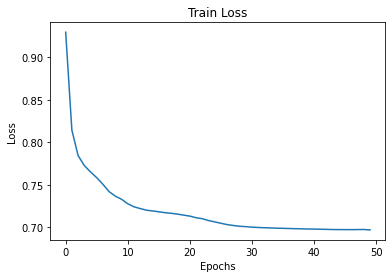

In [11]:
BATCH_SIZE = 1000
EPOCHS = 50

dataset = aenc.CreditscoringDataset("gmsc.csv")      # load and prepare Dataset to Tensor
data_loader = aenc.DataLoader(                       # create Dataloader for batching
    dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True
)

shape = [dataset.x.shape[1], 15, 3, 30, dataset.x.shape[1]]  # define shape of Autoencoder
net = aenc.Autoencoder(shape)
print(net)
net.to("cpu")

train_loss = aenc.train(net, data_loader, EPOCHS)               

plt.figure()
plt.plot(train_loss)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [12]:
# Use trained Autoencoder
net.encode(torch.rand(10, 68))

tensor([[0.9674, 3.7783, 5.3701],
        [1.9904, 3.5464, 6.0015],
        [1.5392, 2.8056, 5.2905],
        [1.8904, 4.2886, 5.2502],
        [2.1164, 4.0511, 5.2508],
        [1.8384, 3.4651, 5.4691],
        [1.7843, 2.5202, 4.3880],
        [1.9714, 2.9180, 6.0598],
        [1.7692, 3.3761, 6.2480],
        [1.4039, 3.6559, 6.0434]], grad_fn=<ReluBackward0>)